In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv


Importing Necessary Modules 

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.cluster import KMeans
import datetime
from datetime import date, timedelta
import folium
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [52]:
t_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv")

In [53]:
DATA = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")

In [54]:
t_data.head(5)

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,49,male,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,47,female,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,50,female,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
t_data.shape

(14126, 45)

In [56]:
#for India
data_In = t_data[t_data['country']=='India']
data_In.shape

(3, 45)

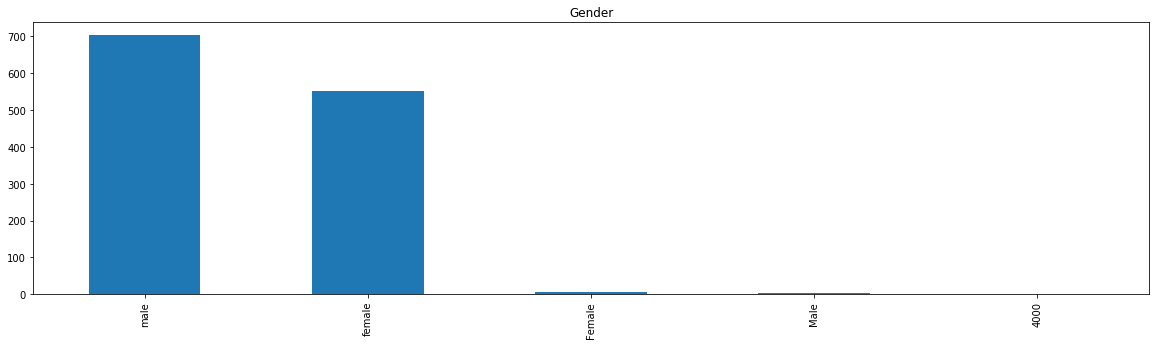

In [57]:
plt.figure(figsize = (20, 5))
plt.title("Gender")
t_data.sex.value_counts().plot.bar();

In [58]:
t_data.isna().sum()

ID                            953
age                         12777
sex                         12862
city                         3932
province                     1220
country                       978
wuhan(0)_not_wuhan(1)         956
latitude                      979
longitude                     979
geo_resolution                979
date_onset_symptoms         13380
date_admission_hospital     13396
date_confirmation            1037
symptoms                    13633
lives_in_Wuhan              13561
travel_history_dates        13623
travel_history_location     13368
reported_market_exposure    14091
additional_information      11714
chronic_disease_binary      14108
chronic_disease             14113
source                       1176
sequence_available          14125
outcome                     13942
date_death_or_discharge     14033
notes_for_discussion        13939
location                    13102
admin3                      12967
admin2                       5058
admin1        

Getting % of Null values in Respective columns

In [59]:
NAN = [(i, t_data[i].isna().mean()*100) for i in t_data]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN

,column_name,percentage
0,ID,6.746425
1,age,90.450234
2,sex,91.051961
3,city,27.835198
4,province,8.636557
5,country,6.923404
6,wuhan(0)_not_wuhan(1),6.767662
7,latitude,6.930483
8,longitude,6.930483
9,geo_resolution,6.930483


In [60]:
t_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,13173.0,6769.250436,3920.886020,1.00000,3351.00000,6865.00000,10180.00000,13479.000000
wuhan(0)_not_wuhan(1),13170.0,1.000000,0.000000,1.00000,1.00000,1.00000,1.00000,1.000000
latitude,13147.0,31.994650,7.536335,-37.81360,27.90538,31.75941,35.78134,69.649468
longitude,13147.0,110.495353,27.985144,-124.95307,111.72960,115.44180,120.44040,153.400000
chronic_disease_binary,18.0,0.722222,0.460889,0.00000,0.25000,1.00000,1.00000,1.000000
Unnamed: 33,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 34,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 35,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 36,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 37,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
NAN = [(i, DATA[i].isna().mean()*100) for i in DATA]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN

,column_name,percentage
0,SNo,0.000000
1,ObservationDate,0.000000
2,Province/State,44.047479
3,Country/Region,0.000000
4,Last Update,0.000000
5,Confirmed,0.000000
6,Deaths,0.000000
7,Recovered,0.000000


Filling "Unknown" in "Province" column where value is null

In [62]:
DATA["Province/State"] = DATA["Province/State"].fillna('Unknown')

In [63]:
DATA[["Confirmed", "Deaths", "Recovered"]] = DATA[["Confirmed", "Deaths", "Recovered"]].astype(int)

In [64]:
DATA.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1,0,0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14,0,0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6,0,0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1,0,0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0,0,0


In [65]:
DATA['Active'] = DATA['Confirmed'] - DATA['Deaths'] - DATA['Recovered']
DATA.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Active
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1,0,0,1
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14,0,0,14
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6,0,0,6
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1,0,0,1
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0,0,0,0


**Overall Effect**

In [66]:
DATA_W = DATA[DATA['ObservationDate'] == max(DATA['ObservationDate'])].reset_index()

In [67]:
Data = DATA_W.groupby(["ObservationDate"])["Confirmed","Active","Recovered","Deaths"].sum().reset_index()
Data

,ObservationDate,Confirmed,Active,Recovered,Deaths
0,03/24/2020,417966,291646,107705,18615


In [68]:
labels = ["Active cases","Recovered","Deaths"]
values = Data.loc[0, ["Active","Recovered","Deaths"]]
fig = px.pie(Data, values=values, names=labels, color_discrete_sequence=['red','lightgreen','darkblue'])
fig.update_layout(
    title= 'Total cases : '+str(Data["Confirmed"][0]),
)
fig.show()

Country-Wise Cases

In [69]:
Country_data = DATA_W.groupby(["Country/Region"])["Confirmed"].sum().reset_index().sort_values("Confirmed",ascending=False).reset_index(drop=True)
Country_data

,Country/Region,Confirmed
0,Mainland China,81180
1,Italy,69176
2,US,53740
3,Spain,39885
4,Germany,32986
...,...,...
166,Timor-Leste,1
167,Eritrea,1
168,Somalia,1
169,Syria,1


**Effect In India**

In [70]:
Data_Ind = DATA[(DATA['Country/Region'] == 'India') ].reset_index(drop=True)
Data_Ind

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Active
0,431,01/30/2020,Unknown,India,1/30/20 16:00,1,0,0,1
1,492,01/31/2020,Unknown,India,1/31/2020 23:59,1,0,0,1
2,548,02/01/2020,Unknown,India,1/31/2020 8:15,1,0,0,1
3,608,02/02/2020,Unknown,India,2020-02-02T06:03:08,2,0,0,2
4,673,02/03/2020,Unknown,India,2020-02-03T21:43:02,3,0,0,3
5,741,02/04/2020,Unknown,India,2020-02-03T21:43:02,3,0,0,3
6,811,02/05/2020,Unknown,India,2020-02-03T21:43:02,3,0,0,3
7,882,02/06/2020,Unknown,India,2020-02-03T21:43:02,3,0,0,3
8,955,02/07/2020,Unknown,India,2020-02-03T21:43:02,3,0,0,3
9,1027,02/08/2020,Unknown,India,2020-02-03T21:43:02,3,0,0,3


In [71]:
Data_ind = Data_Ind.groupby(["ObservationDate"])["Confirmed","Active","Recovered","Deaths"].sum().reset_index()
Data_ind

,ObservationDate,Confirmed,Active,Recovered,Deaths
0,01/30/2020,1,1,0,0
1,01/31/2020,1,1,0,0
2,02/01/2020,1,1,0,0
3,02/02/2020,2,2,0,0
4,02/03/2020,3,3,0,0
5,02/04/2020,3,3,0,0
6,02/05/2020,3,3,0,0
7,02/06/2020,3,3,0,0
8,02/07/2020,3,3,0,0
9,02/08/2020,3,3,0,0


Latest Update

In [72]:
Data_ind_last = Data_ind[Data_ind['ObservationDate'] == max(Data_ind['ObservationDate'])].reset_index()

In [73]:
labels = ["Active case", "Recoverd", "Deaths"]
values = Data_ind_last.loc[0, ["Active","Recovered","Deaths"]]
df = px.data.tips()
fig = px.pie(Data_ind_last, values=values, names=labels, color_discrete_sequence=['red','lightgreen','darkblue'])
fig.update_layout(
    title='Total cases : '+str(Data_ind_last["Confirmed"][0]),
)
fig.show()

In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = Data_ind['ObservationDate'], y = Data_ind['Confirmed'], mode='lines',
                    name='Confirmed cases',marker_color='green'))
fig.add_trace(go.Scatter(x=Data_ind['ObservationDate'], y=Data_ind['Active'], marker_color='darkgrey',mode='lines',
                    name='Active cases',line=dict( dash='dot')))

fig.add_trace(go.Scatter(x=Data_ind['ObservationDate'], y=Data_ind['Deaths'],name='Deaths',
                                   marker_color='red',mode='lines',line=dict( dash='dot') ))
fig.add_trace(go.Scatter(x=Data_ind['ObservationDate'], y=Data_ind['Recovered'], mode='lines',
                    name='Recovered cases',marker_color='blue'))

fig.update_layout(title='Case Progress in India',
)
fig.show()

Applying KMeans for clustering

In [75]:
cluster=Data_ind.loc[:,['id','Active','Confirmed']]
cluster.head(5)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



,id,Active,Confirmed
0,NaN,1,1
1,NaN,1,1
2,NaN,1,1
3,NaN,2,2
4,NaN,3,3


In [76]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(cluster[cluster.columns[1:3]])
cluster['cluster_label'] = kmeans.fit_predict(cluster[cluster.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(cluster[cluster.columns[1:3]])

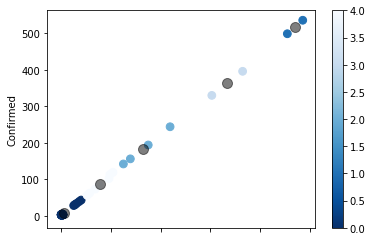

In [77]:
cluster.plot.scatter(x = 'Active', y = 'Confirmed', c=labels, s=60, cmap='Blues_r')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)